In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import sys
sys.path += ['../']

import pandas as pd
from src.utils import *

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/pataki/.conda/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['array', 'subplots', 'random', 'copy', 'uniform', 'partition', 'pad']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
meta = pd.read_csv('/home/pataki/mosquito/data/meta_all_raw.csv')
print(meta.shape)
meta.head()

(7686, 13)


,imgNmb,imgId,rprtId,imgDate,imgTime,imgLon,imgLat,imgClass,imgLabel,hidden,year,file,isTiger
0,2014_000091.png,f2a43106-6ca7-4dc0-a576-3526101ad1e7,56dfd08a-a2f3-42b3-b0ad-dcf89dfce164,2014-06-18,18:13:54,2.7925459999999998,41.970585,Ae.albopictus,probable,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1
1,2014_000099.png,f67df72f-e181-486d-b3b3-140a4f8d27f8,7fe6dc17-5858-4800-a864-4838f8a427c5,2014-06-21,19:53:58,-0.834205,37.759853,Ae.albopictus,probable,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1
2,2014_000105.png,5e6952dc-09e6-4468-9f96-441660b1a45f,e727b596-f443-45ce-bc64-d392893ad746,2014-06-23,04:51:45,2.253791,41.45605,Ae.albopictus,confirmed,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1
3,2014_000119.png,1d4a81e7-f1c1-45e1-aa75-d15ca04e20f6,33c47455-74c4-492f-9775-c722c668dd97,2014-06-23,20:18:04,0.48081899999999994,40.48278,Ae.albopictus,probable,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1
4,2014_000144.png,aa7137aa-2d41-4243-8ed9-6e6797babe18,2d9999e2-a1ec-4410-bab8-b1461de2c13e,2014-06-27,17:01:12,2.114958,41.381565,Ae.albopictus,probable,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1


In [4]:
np.random.seed(42)
meta = meta.sample(frac=1)
meta = meta[meta.year != 2014]
meta = meta.groupby('year').head(1000).reset_index()

In [5]:
Counter(meta.year)

Counter({2016: 1000, 2019: 1000, 2018: 1000, 2015: 1000, 2017: 1000})

In [6]:
pred_dict = {}
label_dict = {}
testyear_dict = {}
for y in [2015, 2016, 2017, 2018, 2019]:
    years = meta[meta.year != y].year.tolist()    
    preds, labels = train_predict(df_train = meta[meta.year == y][['file', 'isTiger']], 
                                  df_test =  meta[meta.year != y][['file', 'isTiger']], 
                                  path='/')

    pred_dict[y]     = preds
    label_dict[y]    = labels
    testyear_dict[y] = years
    
    assert (np.array(labels) == meta[meta.year != y].isTiger.values).all()

epoch,train_loss,valid_loss,error_rate,AUROC,time
0,1.223390,1.251712,0.441750,0.569634,01:12
1,0.886522,0.725762,0.296250,0.637653,00:25
2,0.576359,0.588131,0.226750,0.737708,00:25
3,0.384430,0.606501,0.215500,0.789905,00:25
4,0.265978,0.594129,0.215000,0.796187,00:25


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.151020,0.612665,0.217500,0.818565,00:28
1,0.126205,0.535810,0.190250,0.824279,00:27
2,0.116262,0.558516,0.191000,0.822089,00:28
3,0.101948,0.544369,0.186000,0.817338,00:27
4,0.086516,0.548244,0.193000,0.819028,00:27


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,1.103859,1.051794,0.309500,0.803089,00:25
1,0.826720,0.591583,0.197250,0.834500,00:25
2,0.564485,0.460124,0.157500,0.848432,00:25
3,0.443023,0.406825,0.144000,0.864476,00:25
4,0.347182,0.403776,0.148500,0.867144,00:25


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.228556,0.384223,0.127250,0.879678,00:27
1,0.206954,0.447566,0.162250,0.845995,00:28
2,0.195415,0.400384,0.125000,0.879082,00:28
3,0.157076,0.370556,0.117500,0.887454,00:27
4,0.137261,0.369497,0.119750,0.890077,00:28


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,1.304588,0.991885,0.262000,0.813816,00:25
1,0.913835,0.501516,0.197750,0.815554,00:25
2,0.613287,0.409978,0.158750,0.862373,00:25
3,0.444771,0.369031,0.141750,0.871347,00:25
4,0.339053,0.362904,0.140500,0.876023,00:25


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.208001,0.370333,0.137250,0.883236,00:28
1,0.208967,0.344604,0.125750,0.892274,00:28
2,0.181293,0.339096,0.118000,0.898479,00:28
3,0.164793,0.323408,0.119000,0.906748,00:28
4,0.126766,0.315771,0.110500,0.908658,00:28


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,1.018650,0.977840,0.278250,0.810219,00:25
1,0.815813,0.646438,0.202000,0.825894,00:25
2,0.621295,0.433870,0.162500,0.862344,00:25
3,0.485914,0.366683,0.136500,0.875556,00:25
4,0.406751,0.361888,0.136250,0.879217,00:25


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.270359,0.344845,0.123000,0.897475,00:27
1,0.281757,0.340212,0.118750,0.902117,00:28
2,0.221919,0.329279,0.111250,0.908560,00:28
3,0.181706,0.368852,0.123500,0.896863,00:27
4,0.151118,0.332857,0.113500,0.909241,00:28


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,1.092264,0.929478,0.263250,0.821136,00:25
1,0.865879,0.575340,0.204000,0.851788,00:25
2,0.651909,0.416953,0.165750,0.847190,00:25
3,0.493945,0.406598,0.162000,0.862732,00:25
4,0.414663,0.394799,0.161500,0.866758,00:25


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.273728,0.358974,0.128750,0.882095,00:27
1,0.275747,0.373555,0.142750,0.879080,00:27
2,0.242475,0.356266,0.137250,0.905767,00:28
3,0.191463,0.325462,0.120250,0.910782,00:28
4,0.152046,0.324930,0.123500,0.911133,00:28


In [11]:
def get_year_year_metric(train_year, test_year, metric, n_bootstrap=500):
    np.random.seed(42)
    all_preds  = np.array(pred_dict[train_year])
    all_labels = np.array(label_dict[train_year])
    all_years  = np.array(testyear_dict[train_year])
    
    preds  = all_preds[all_years == test_year]
    labels = all_labels[all_years == test_year]
    
    metric_num = []
    for k in range(n_bootstrap):
        idxs = np.random.choice(range(len(labels)), len(labels))
        if metric == 'AUC':
            metric_num.append(roc_auc_score(y_true = labels[idxs], y_score = preds[idxs][:,1]))
        if metric == 'ACC':
            metric_num.append((labels[idxs] ==  (preds[idxs][:,1] > 0.5)).mean())
    return np.mean(metric_num), np.std(metric_num)

In [12]:
get_year_year_metric(train_year=2015, test_year=2016, metric='AUC')

(0.8319481487892317, 0.016408924432144707)

In [13]:
acc_df = pd.DataFrame({2015:[0., 0, 0, 0, 0],
              2016:[0., 0, 0, 0, 0],
              2017:[0., 0, 0, 0, 0],
              2018:[0., 0, 0, 0, 0],
              2019:[0., 0, 0, 0, 0]}, 
              index=['2015', '2016', '2017', '2018', '2019'])
acc_df.index.name = 'train_year'

auc_df = pd.DataFrame({2015:[0., 0, 0, 0, 0],
              2016:[0., 0, 0, 0, 0],
              2017:[0., 0, 0, 0, 0],
              2018:[0., 0, 0, 0, 0],
              2019:[0., 0, 0, 0, 0]}, 
              index=['2015', '2016', '2017', '2018', '2019'])
auc_df.index.name = 'train_year'

In [14]:
for train_y in [2015, 2016, 2017, 2018, 2019]:
    for test_y in [2015, 2016, 2017, 2018, 2019]:
        if train_y == test_y:
            continue
        mean, std = get_year_year_metric(train_year=train_y, test_year=test_y, metric='AUC')
        auc_df.at[str(train_y), test_y] = np.round(mean, 3) #'+/-{np.round(std, 3)}'
        
        mean, std = get_year_year_metric(train_year=train_y, test_year=test_y, metric='ACC')
        acc_df.at[str(train_y), test_y] = np.round(mean, 3) #+/-{np.round(std, 3)}'

In [15]:
for train_y in [2015, 2016, 2017, 2018, 2019]:
    auc_df.at[str(train_y), train_y] = np.nan
    acc_df.at[str(train_y), train_y] = np.nan

In [17]:
import seaborn as sns

In [26]:
a = meta.groupby(['year', 'isTiger']).count().reset_index()
a.pivot(index='year', columns='isTiger', values='index').T

year,2015,2016,2017,2018,2019
isTiger,,,,,
False,58,241,210,283,297
True,942,759,790,717,703


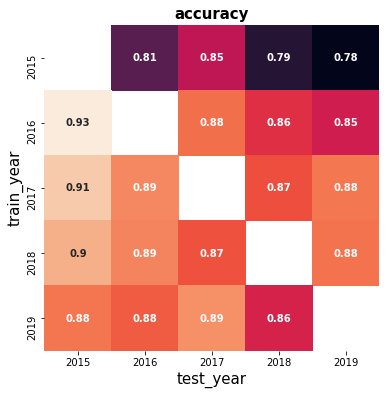

In [39]:
plt.figure(figsize=(6, 6))
sns.heatmap(acc_df, annot=True, clim=(0.8, 1), cbar=False, annot_kws={'fontweight':'bold'})
plt.xlabel('test_year', fontsize=15)
plt.ylabel('train_year', fontsize=15)
plt.title('accuracy', fontsize=15, fontweight='bold')
plt.show()

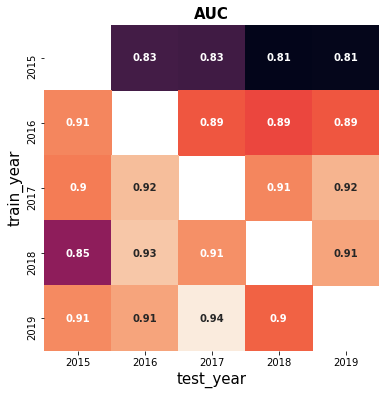

In [40]:
plt.figure(figsize=(6, 6))
sns.heatmap(auc_df, annot=True, clim=(0.8, 1), cbar=False, annot_kws={'fontweight':'bold'})
plt.xlabel('test_year', fontsize=15)
plt.ylabel('train_year', fontsize=15)
plt.title('AUC', fontsize=15, fontweight='bold')
plt.show()